# Contents

[**1. Get the relevant data from SQL DB**](#get_data)

[**2. Clean the data**](#clean_data)

[**3. Bag of words, TF-IDF and similarity metric**](#bow)

[**4. Word2vec and Word Mover's Distance**](#wmd)

[**5. Generate the learning curve**](#learning_curve)

[**6. Slackbot**](#slackbot)

---

In [40]:
import psycopg2, nltk, gensim, subprocess, re, time, sys, os, spacy
import pandas as pd
import numpy as np

from slackclient import SlackClient
from __future__ import division

from pyemd import emd
from sklearn.metrics import euclidean_distances
from sklearn.metrics import accuracy_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # For pretty plots
%config InlineBackend.figure_format='retina'

---

# <a name="get_data">1. Get the relevant data from SQL DB</a>

Open my Postgres app

In [2]:
#subprocess.call(["/usr/bin/open", "-n", "-a", "/Applications/Postgres.app"]);

Connect to DB and pull the comments from all the subreddits we have:

In [3]:
con = psycopg2.connect(database = 'slack_police', user = 'aficnar')

In [4]:
all_subreddits = pd.read_sql("SELECT id FROM main_subreddits", con)['id'].tolist()
all_subreddit_names = pd.read_sql("SELECT name FROM main_subreddits", con)['name'].tolist()
print all_subreddit_names
print all_subreddits

['diving', 'Handball', 'corgi', 'datascience', 'MachineLearning']
['2qr9w', '2rr72', '2rdw8', '2sptq', '2r3gv']


In [5]:
data = []
for subreddit_id in all_subreddits:
    sql_query = "SELECT content FROM main_comments WHERE subreddit_id = '%s'" % subreddit_id
    data_local = pd.read_sql(sql_query, con)['content'].tolist()
    data.append(data_local)

In [6]:
lengths = [len(datum) for datum in data]
lengths

[5111, 5885, 5006, 5008, 5013]

---

# <a name="clean_data">2. Clean the data</a>

Get rid of the Emojis

In [7]:
emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"   # flags (iOS)
    "+", flags = re.UNICODE)

Load stopping words and initialize the stemmer:

In [8]:
stopset = set(stopwords.words('english'))
my_stopset = set(['would', 'http', 'also', 'com']).union(stopset)
stemmer = nltk.PorterStemmer()

Function that takes a post, cleans it and returns list of tokens:

In [9]:
def clean_post(post, stem = True):
    if type(post) == str: conv_post = unicode(post, "utf-8")
    else: conv_post = post
    u_post = emoji_pattern.sub('', conv_post)
    u_post_let = re.sub("[^a-zA-Z]", " ", u_post) # Only words, for now
    tokens = WordPunctTokenizer().tokenize(u_post_let)
    clean = [token.lower() for token in tokens if token.lower() not in my_stopset and len(token) > 2]
    if stem == True: final = [stemmer.stem(word) for word in clean]
    else: final = clean
    return final

Tokenize our datasets (watch for the **`stem`** option)

In [10]:
data_tokenized = [[clean_post(comment, stem = False) for comment in datum] for datum in data]
print data_tokenized[0][0]

[u'dan', u'widely', u'recognised', u'qld', u'seen', u'dive', u'assured', u'anywhere', u'mean', u'available', u'seen']


---

# <a name="bow">3. Bag of words, TF-IDF and similarity</a>

We'll use `scikit-learn`'s BOW generator which needs full strings:

In [11]:
data_clean = [[" ".join(tokens) for tokens in datum] for datum in data_tokenized]
print data_clean[0][0]

dan widely recognised qld seen dive assured anywhere mean available seen


Remove all the zero-length entries

In [12]:
data_clean = [filter(None, datum) for datum in data_clean]
[np.sum([len(d) == 0 for d in datum]) for datum in data_clean]

[0, 0, 0, 0, 0]

In [13]:
all_clean = [item for sublist in data_clean for item in sublist]

Generate the BOW for the entire corpus:

In [14]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                             preprocessor = None, stop_words = None, 
                             max_features = 5000) 

In [15]:
all_bow = vectorizer.fit_transform(all_clean)
all_bow_array = all_bow.toarray()
all_bow_array.shape

(25843, 5000)

Let's look at the most common words:

In [16]:
vocabulary = vectorizer.get_feature_names()
counts = np.sum(all_bow_array, axis = 0)

In [17]:
len(vocabulary)

5000

In [18]:
top_words = pd.DataFrame({'word': vocabulary, 'count': counts}).sort_values(by = 'count', ascending = False)
top_series = top_words['count']
top_series.index = top_words['word']
top_series[:5]

word
data    4655
like    4037
get     3228
one     3211
good    2883
Name: count, dtype: int64

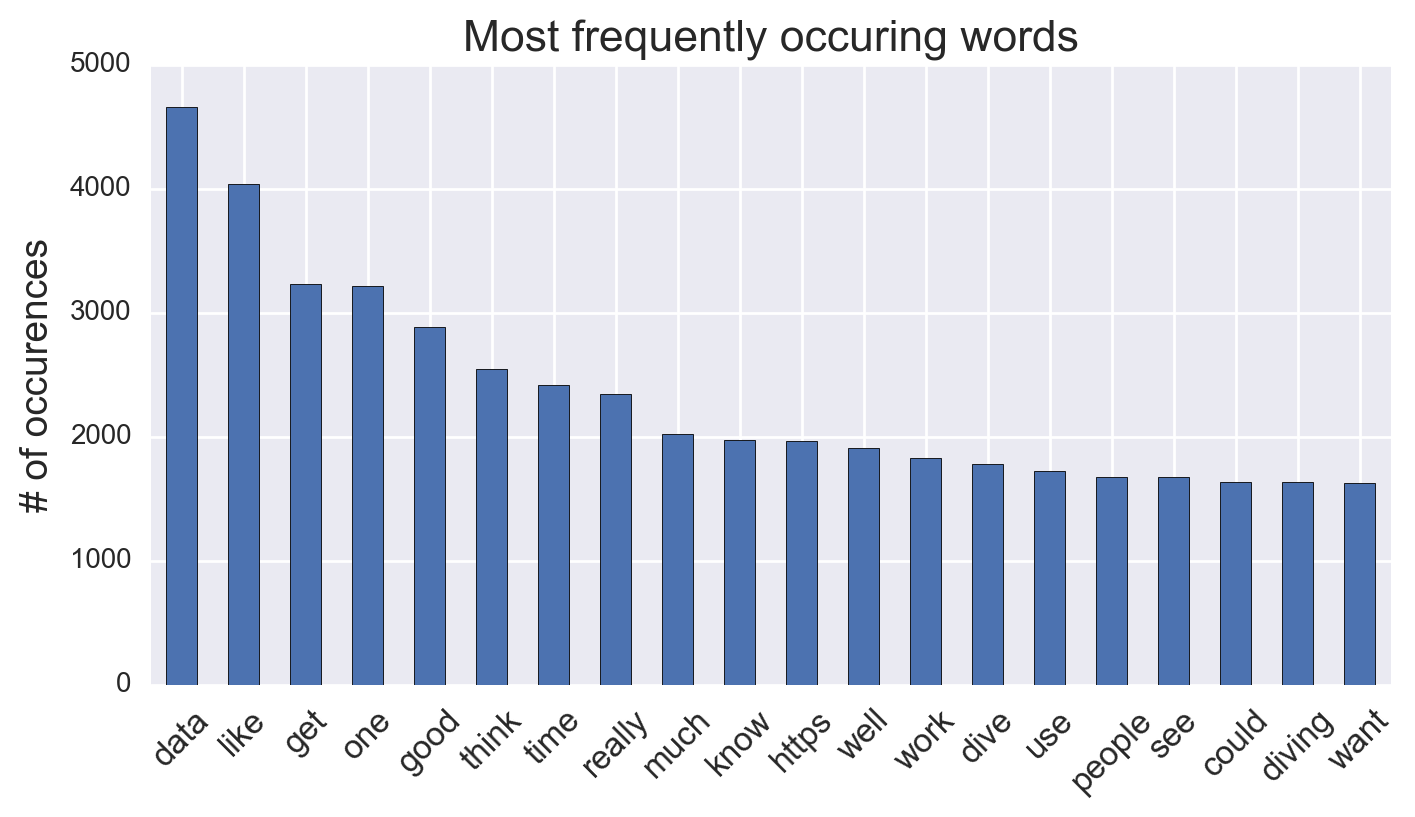

In [19]:
fig, ax = plt.subplots(figsize = (8, 4))
top_series[:20].plot.bar(ax = ax)
ax.set_xticklabels(top_series[:20].index.tolist(), rotation = 45, fontsize = 12)
ax.set_xlabel("", fontsize = 12)
ax.set_ylabel('# of occurences', fontsize = 14)
ax.set_title('Most frequently occuring words', fontsize = 16);

Let's look at most frequently occuring words in each subreddit:

In [20]:
freqs_list = []
for datum in data_clean:
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                                 preprocessor = None, stop_words = None, 
                                 max_features = 5000)
    this_bow = vectorizer.fit_transform(datum)
    this_bow_array = this_bow.toarray()
    vocabulary = vectorizer.get_feature_names()
    counts = np.sum(this_bow_array, axis = 0)
    top_words = pd.DataFrame({'word': vocabulary, 'count': counts}).sort_values(by = 'count', ascending = False)
    top_series = top_words['count']
    top_series.index = top_words['word']
    freqs_list.append(top_series)

Plot the relative frequencies:

In [21]:
rel_freq_list = [f / f.sum() for f in freqs_list]

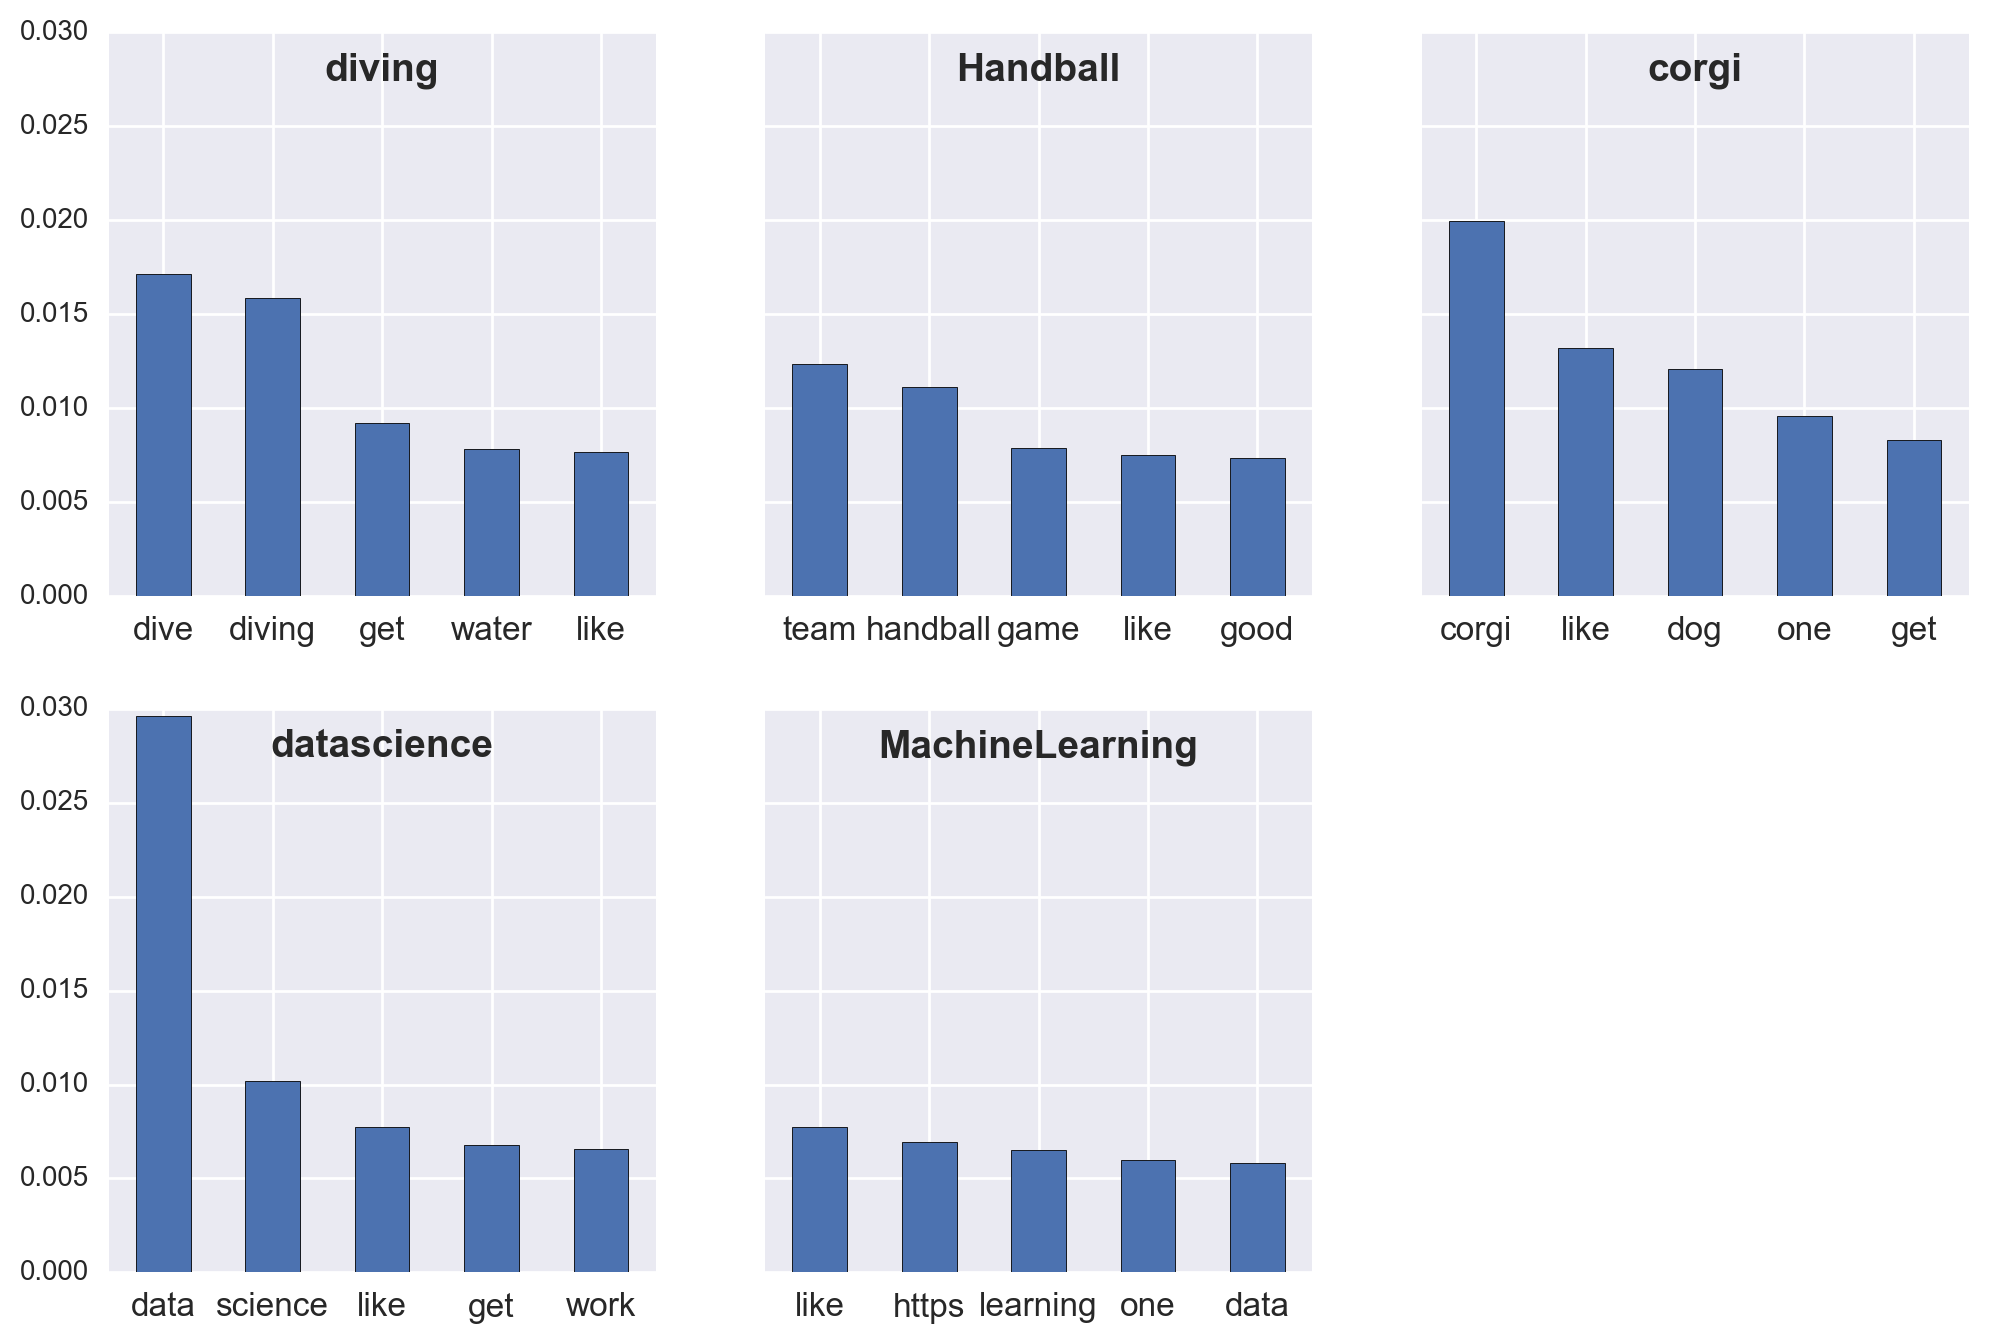

In [22]:
fig, axes = plt.subplots(2, 3, sharex = False, sharey = True, figsize = (12, 8))
cnt = 0
for i in range(2):
    for j in range(3):
        if cnt <= 4:
            rel_freq_list[cnt][:5].plot.bar(ax = axes[i, j])
            #axes[i, j].set_title(all_subreddit_names[cnt], fontweight="bold")
            axes[i, j].set_xticklabels(rel_freq_list[cnt][:5].index.tolist(), rotation = 0, fontsize = 12)
            axes[i, j].set_xlabel("", fontsize = 12)
            axes[i, j].text(0.5, 0.915, all_subreddit_names[cnt], fontweight="bold", fontsize =14, 
                            horizontalalignment = 'center', transform = axes[i, j].transAxes)
            cnt = cnt + 1
        else: 
            axes[i, j].axis('off')

In [23]:
fig.savefig('frequencies.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

Now, the idea is to generate TF-IDF from BOW and use a simple cosine similarity as a baby version of the full word2vec + WMD problem:

In [24]:
transformer = TfidfTransformer()
all_tfidf = transformer.fit_transform(all_bow_array)
cosine_similarities = linear_kernel(all_tfidf[0:1], all_tfidf).flatten()

---

# <a name="wmd">4. Word2vec and Word Mover's Distance</a>

Initialize the language pipeline

In [27]:
vectorizer = CountVectorizer(stop_words = None)
nlp = spacy.load('en')

Calculate the WMD distance between two strings

In [28]:
def wmd(s1, s2):
    vect_fit = vectorizer.fit([s1, s2])
    spacy_words = nlp(" ".join(vect_fit.get_feature_names()))
    v_1, v_2 = vect_fit.transform([s1, s2])
    v_1 = v_1.toarray().ravel().astype(np.double)
    v_2 = v_2.toarray().ravel().astype(np.double)
    v_1 /= v_1.sum()
    v_2 /= v_2.sum()    
    w2v_vectors = [w.vector for w in spacy_words]
    dist_matrix = euclidean_distances(w2v_vectors).astype(np.double)
    #dist_matrix /= dist_matrix.max()
    return emd(v_1, v_2, dist_matrix)

Function to check if a word is in the vocabulary:

In [28]:
def oov_checker(s):
    if type(s) == str: s = unicode(s, "utf-8")
    return nlp(s)[0].is_oov

Function to check if a word is in vocabulary AND is either a noun, a verb or an adjective:

In [29]:
pos_set = set([u'NOUN', u'ADJ', u'VERB'])
def oov_checker_plus(s):
    if type(s) == str: s = unicode(s, "utf-8")
    is_oov = nlp(s)[0].is_oov
    is_info_word = nlp(s)[0].pos_ in pos_set
    return (not is_oov) and is_info_word

Only include the tokens that satisfy this and remove the examples that are empty:

In [30]:
data_tokenized_nlp = [[[t for t in tokens if oov_checker_plus(t) == True] 
                       for tokens in datum] for datum in data_tokenized]
data_clean_nlp = [[" ".join(tokens) for tokens in datum] for datum in data_tokenized_nlp]
data_clean_nlp = [filter(None, datum) for datum in data_clean_nlp]
[np.sum([len(d) == 0 for d in datum]) for datum in data_clean_nlp]

[0, 0, 0, 0, 0]

Check that there are indeed no out-of-vocab words in the corpus:

In [31]:
oov_count = 0
for datum in data_clean_nlp:
    for example in datum:
        oov_bool = [w.is_oov for w in nlp(example)]
        oov_count = oov_count + np.sum(oov_bool)
oov_count

0

---

## Modified WMD

The function that gives the modified WMD distance between the input and the channel representative:

In [33]:
def wmd2(s1, i_cat, no_top):
    s2 = " ".join(rel_freq_list[i_cat].index.tolist()[:no_top])
    vect_fit = vectorizer.fit([s1, s2])
    spacy_words = nlp(" ".join(vect_fit.get_feature_names()))  
    v_1, v_2 = vect_fit.transform([s1, s2])
    v_1 = v_1.toarray().ravel().astype(np.double)
    v_2 = v_2.toarray().ravel().astype(np.double)
    for i_s in range(len(v_2)):
        if str(spacy_words[i_s]) in rel_freq_list[i_cat][:no_top]:
            v_2[i_s] = rel_freq_list[i_cat][str(spacy_words[i_s])]
        else: 
            v_2[i_s] = 0
    v_1 /= v_1.sum()
    v_2 /= v_2.sum()    
    w2v_vectors = [w.vector for w in spacy_words]
    dist_matrix = euclidean_distances(w2v_vectors).astype(np.double)
    #dist_matrix /= dist_matrix.max()
    return emd(v_1, v_2, dist_matrix)

Define the test set:

In [35]:
test_size = 50

In [36]:
test_clean = []
for datum in data_clean_nlp:
    test_clean = test_clean + datum[0: test_size]

In [37]:
true_labels = []
for name in all_subreddit_names: 
    true_labels = true_labels + [name] * test_size

Select the number of words in the representative sentences:

In [38]:
top_words_list = range(10, 200, 20)
top_words_list

[10, 30, 50, 70, 90, 110, 130, 150, 170, 190]

In [204]:
acc_list = []
for no_top in top_words_list:
    print no_top
    wmd_labels = []
    for i_test in range(len(test_clean)):
        wmd_avgs = [wmd2(test_clean[i_test], i, no_top) for i in range(len(data))]
        index_min = wmd_avgs.index(min(wmd_avgs))
        wmd_labels = wmd_labels + [all_subreddit_names[index_min]]
    acc_list.append(accuracy_score(true_labels, wmd_labels))

10
30
50
70
90
110
130
150
170
190


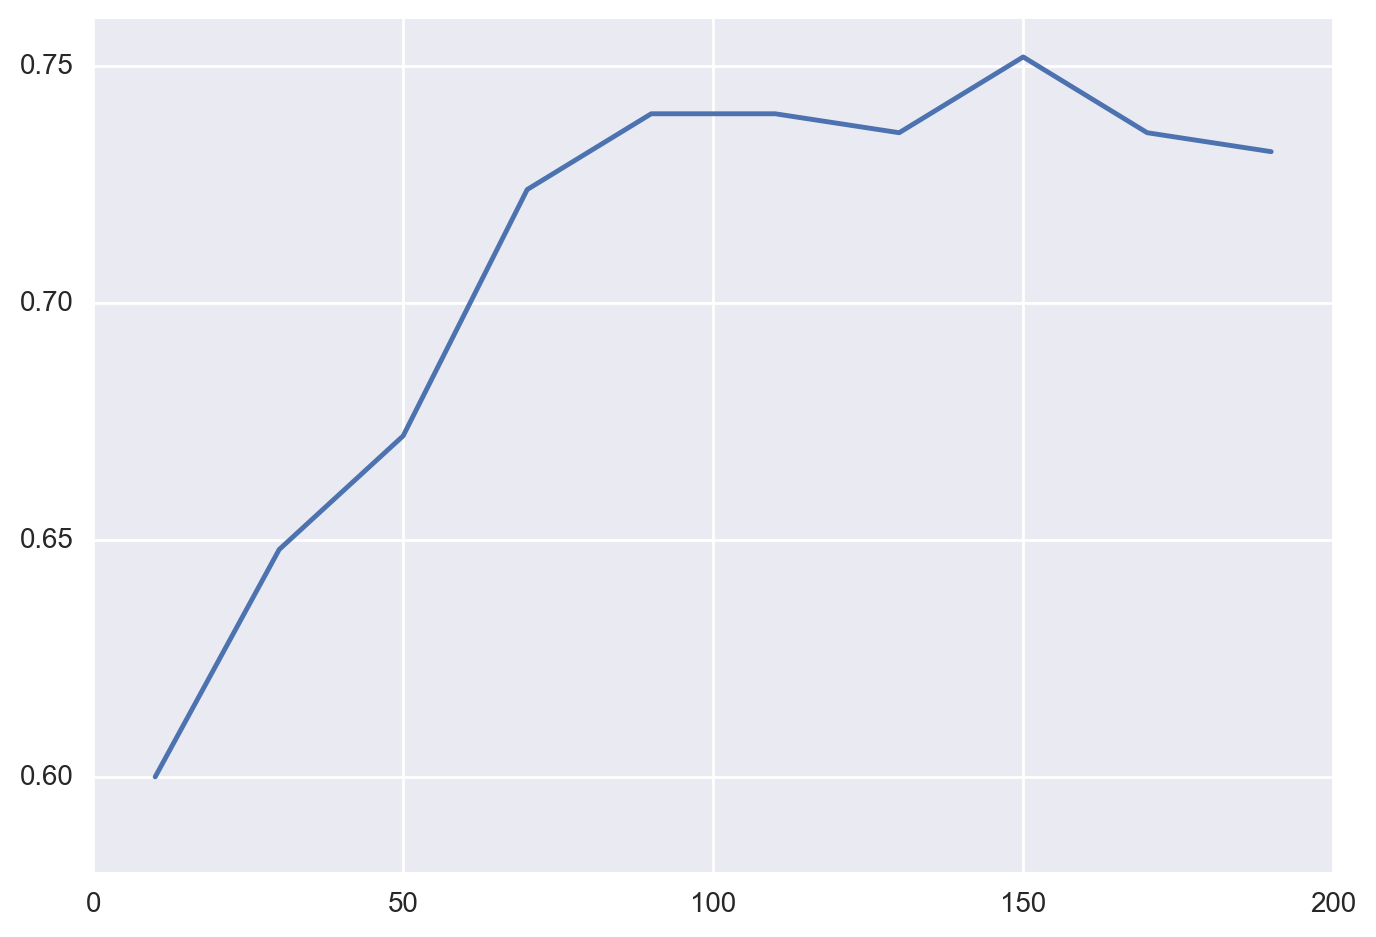

In [205]:
plt.plot(top_words_list, acc_list);

Let's focus on the best case scenario and calculate the confusion matrix

In [41]:
test_size = 50
wmd_labels = []
for i_test in range(len(test_clean)):
    wmd_avgs = [wmd2(test_clean[i_test], i, 150) for i in range(len(data))]
    index_min = wmd_avgs.index(min(wmd_avgs))
    wmd_labels.append(all_subreddit_names[index_min])
accuracy_score(true_labels, wmd_labels)

0.752

In [42]:
conf_mat_maj = pd.DataFrame(confusion_matrix(true_labels, wmd_labels, labels = all_subreddit_names), 
                            index = all_subreddit_names, columns = all_subreddit_names)
conf_mat_maj

,diving,Handball,corgi,datascience,MachineLearning
diving,44,0,0,1,5
Handball,5,38,3,2,2
corgi,11,1,31,1,6
datascience,1,0,0,45,4
MachineLearning,4,1,4,11,30


Let's look at the examples we got wrong:

In [43]:
scores = [[wmd2(example, i, 150) for example in test_clean] for i in range(len(data))]

In [44]:
outcome_df = pd.DataFrame({"post":test_clean, "true":true_labels, "prediction":wmd_labels, 
                          all_subreddit_names[0]: scores[0], all_subreddit_names[1]: scores[1],
                          all_subreddit_names[2]: scores[2],all_subreddit_names[3]: scores[3],
                          all_subreddit_names[4]: scores[4]},
                          columns = ["post", "true",  "prediction", all_subreddit_names[0],all_subreddit_names[1],
                                    all_subreddit_names[2], all_subreddit_names[3], all_subreddit_names[4]])

In [45]:
outcome_df[outcome_df['true'] != outcome_df['prediction']]

,post,true,prediction,diving,Handball,corgi,datascience,MachineLearning
7,make video private distribute password reddit ...,diving,MachineLearning,6.718229,6.931300,6.818229,6.587000,6.499714
20,plan get taking course certification wide vari...,diving,datascience,5.648988,6.042161,5.954067,5.644299,5.732253
35,messaging utc www wolframalpha input utc local...,diving,MachineLearning,6.645320,7.063594,6.867561,6.724671,6.350605
38,keys,diving,MachineLearning,7.711658,7.907704,7.844079,7.681644,7.627888
41,looks interested everybody favourite cephalopo...,diving,MachineLearning,6.315935,6.466703,6.429022,6.332228,6.174825
47,best bot,diving,MachineLearning,6.615782,6.657010,6.636865,6.595445,6.532593
50,compute,Handball,datascience,8.116669,8.243121,8.264972,7.732490,7.749823
51,going send,Handball,diving,5.836438,6.084377,5.918774,5.853828,5.841248
52,got anxiety watching horse race,Handball,corgi,6.820062,6.876932,6.709978,7.005348,6.996822
56,mind explain give english link something happened,Handball,MachineLearning,5.719011,5.809689,5.711888,5.575752,5.551725


Let's implement a simple threshold:

In [256]:
thresh_list = [0.001, 0.01, 0.02, 0.05]
acc_list = []
for thresh in thresh_list:
    print thresh
    test_size = 50
    wmd_labels = []
    flagged = []
    for i_test in range(len(test_clean)):
        wmd_avgs = [wmd2(test_clean[i_test], i, 150) for i in range(len(data))]
        index_min = wmd_avgs.index(min(wmd_avgs))
        top_indices = np.argsort(wmd_avgs)
        diff = np.abs(wmd_avgs[top_indices[0]] - wmd_avgs[top_indices[1]]) / wmd_avgs[top_indices[0]]
        wmd_labels.append(all_subreddit_names[index_min])
    
        if diff > thresh: 
            flagged.append(False)
        else:
            flagged.append(True)
    correct_count = 0
    for i in range(len(test_clean)):
        if true_labels[i] == wmd_labels[i] and flagged[i] == False: correct_count = correct_count + 1
        if true_labels[i] != wmd_labels[i] and flagged[i] == True: correct_count = correct_count + 1
    acc_list.append(correct_count / len(test_clean))
    

0.001
0.01
0.02
0.05


In [257]:
acc_list

[0.756, 0.764, 0.724, 0.596]

---

## Work in progress: trying out WMD on all entries

In [344]:
train_size = 300
test_size = 10

In [345]:
train_clean = []
for datum in data_clean_nlp:
    train_clean = train_clean + datum[0: train_size]
test_clean = []
for datum in data_clean_nlp:
    test_clean = test_clean + datum[train_size: train_size + test_size]

In [346]:
oov_count = 0
total_words = 0
for example in train_clean:
    if len(example) > 0:
        oov_bool = [w.is_oov for w in nlp(example)]
        total_words = total_words + len(oov_bool)
        oov_count = oov_count + np.sum(oov_bool)
oov_count / total_words

0.0

In [347]:
true_labels = []
for name in all_subreddit_names: 
    true_labels = true_labels + [name] * test_size

In [348]:
wmd_matrix = np.zeros((len(train_clean), len(test_clean)))

In [349]:
for i_test in range(len(test_clean)):
    output_string = "\rTest example " + str(i_test + 1) + " / " + str(len(test_clean))
    sys.stdout.write(output_string)
    sys.stdout.flush()
    for i_train in range(len(train_clean)):
        wmd_matrix[i_train, i_test] = wmd(test_clean[i_test], train_clean[i_train])

Test example 50 / 50

In [350]:
maj_labels = []
for i_test in range(len(test_clean)):
    wmd_avgs = [np.mean(row) for row in np.split(wmd_matrix[:, i_test], len(data_clean))]
    index_min = wmd_avgs.index(min(wmd_avgs))
    maj_labels = maj_labels + [all_subreddit_names[index_min]]
accuracy_score(true_labels, maj_labels)

0.52000000000000002

In [351]:
conf_mat_maj = pd.DataFrame(confusion_matrix(true_labels, maj_labels, labels = all_subreddit_names), 
                            index = all_subreddit_names, columns = all_subreddit_names)
conf_mat_maj

,diving,Handball,corgi,datascience,MachineLearning
diving,5,1,0,4,0
Handball,0,9,0,1,0
corgi,1,4,1,4,0
datascience,0,0,0,10,0
MachineLearning,0,0,0,9,1


In [352]:
outcome_df = pd.DataFrame({"post":test_clean, "true":true_labels, "prediction":maj_labels}, 
                          columns = ["post", "true",  "prediction"])
outcome_df.head(10)

,post,true,prediction
0,count pool good marine life much diving france...,diving,diving
1,good luck jules lodge bad early morning,diving,Handball
2,good waves doesnt change,diving,datascience
3,reef something,diving,diving
4,juat called cant today going lake underwater h...,diving,datascience
5,underwater hotel sick sounds better reef dive,diving,diving
6,visibility murky waters dude underwear spied,diving,diving
7,thank started looking locations recommend adva...,diving,datascience
8,sites area little bit deeper helps confidence ...,diving,datascience
9,stayed atlantis resort loved loved diving,diving,diving


In [389]:
np.linspace(0.01,0.2,20)

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ])

In [391]:
thresh_list = np.linspace(0.01,0.2,20)
index_fix = 0

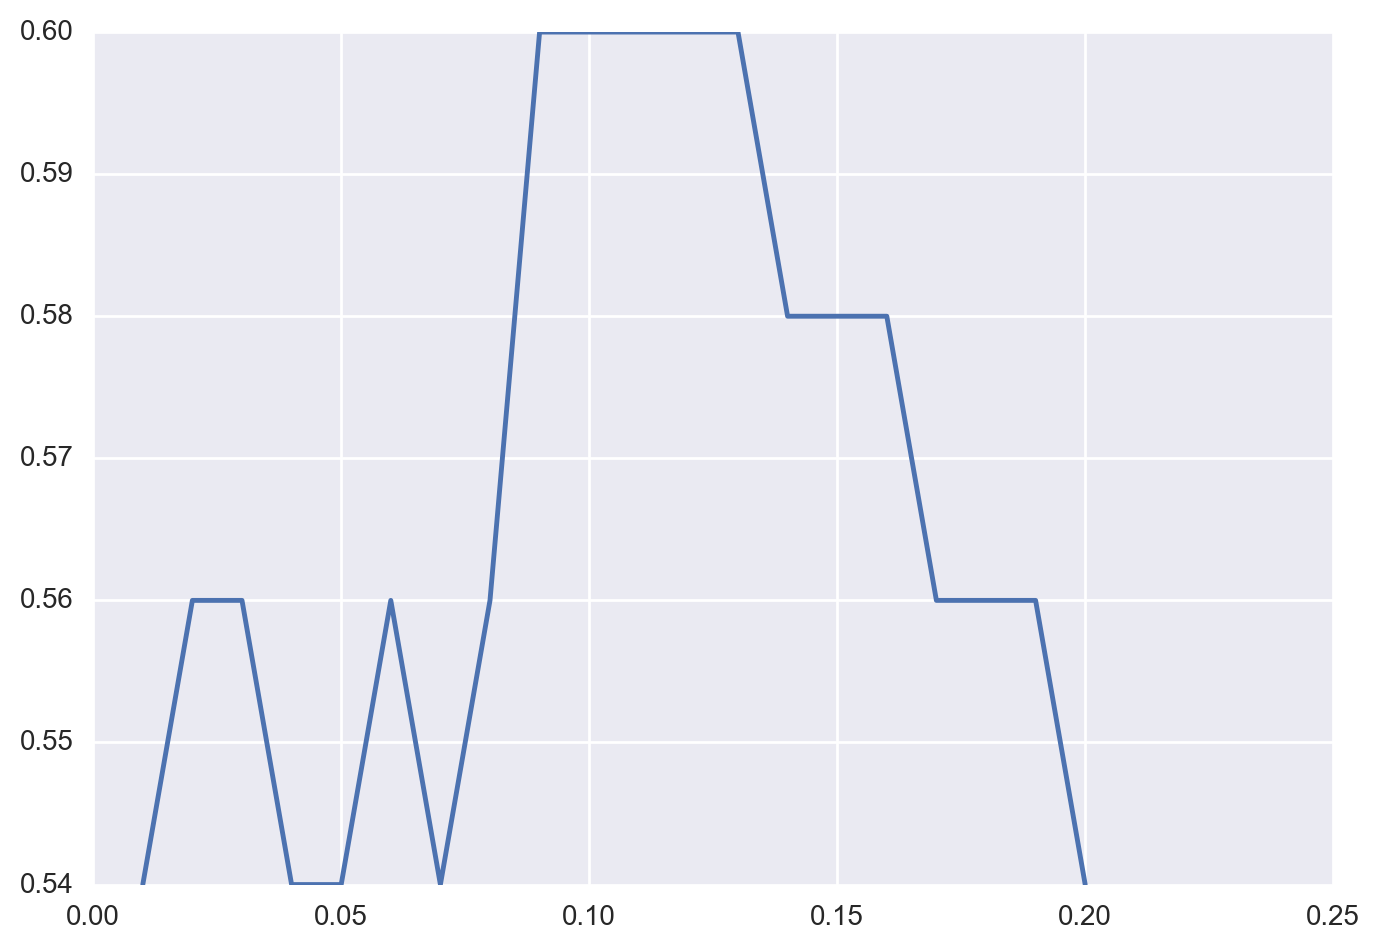

In [399]:
thresh_list = np.linspace(0.01,0.2,20)
index_fix = 4
acc_list = []
for thresh in thresh_list:
    maj_labels = []
    for i_test in range(len(test_clean)):
        wmd_avgs = [np.mean(row) for row in np.split(wmd_matrix[:, i_test], len(data_clean))]
        index_min = wmd_avgs.index(min(wmd_avgs))
        #index_local = all_subreddit_names.index(true_labels[i_test])
        index_local = index_fix
        if abs(wmd_avgs[index_min] - wmd_avgs[index_local]) > thresh: 
            label_predicted = all_subreddit_names[index_min]
        else:
            label_predicted = all_subreddit_names[index_local]
        maj_labels = maj_labels + [label_predicted]
    acc_list.append(accuracy_score(true_labels, maj_labels))
plt.plot(thresh_list, acc_list);

In [356]:
test_id = 4
test_clean[test_id]

u'juat called cant today going lake underwater hotel keys reefs'

In [357]:
wmd_test = [wmd(test_clean[test_id], example) for example in train_clean]

In [358]:
wmd_test_split = np.split(np.array(wmd_test), len(data_clean))
train_clean_split = np.split(np.array(train_clean), len(data_clean))

In [359]:
[np.mean(chunk) for chunk in wmd_test_split]

[7.2023162757917305,
 7.1773304059362601,
 7.6354324374616924,
 7.1701020471030761,
 7.2525164995543214]

In [361]:
wmd_test_split[0][np.argsort(wmd_test_split[0])][:5]

array([ 5.8284369 ,  5.94073271,  6.07149689,  6.10896501,  6.16085753])

In [362]:
wmd_test_split[3][np.argsort(wmd_test_split[3])][:5]

array([ 5.97494959,  6.0913395 ,  6.10328616,  6.17122104,  6.17189699])

In [366]:
k = 50
knn_labels = []
for i_test in range(len(test_clean)):
    top_indices = np.argsort(wmd_matrix[:, i_test]) // train_size
    index_min = np.argmax(np.bincount(top_indices[:k]))
    knn_labels = knn_labels + [all_subreddit_names[index_min]]
conf_mat_knn = pd.DataFrame(confusion_matrix(true_labels, knn_labels, labels = all_subreddit_names), 
                            index = all_subreddit_names, columns = all_subreddit_names)
conf_mat_knn

,diving,Handball,corgi,datascience,MachineLearning
diving,6,1,2,1,0
Handball,0,8,1,0,1
corgi,0,1,8,1,0
datascience,0,0,0,7,3
MachineLearning,0,1,0,6,3


In [368]:
acc_list = []
for kk in range(1, 100):
    knn_labels = []
    for i_test in range(len(test_clean)):
        top_indices = np.argsort(wmd_matrix[:, i_test]) // train_size
        index_min = np.argmax(np.bincount(top_indices[:kk]))
        knn_labels = knn_labels + [all_subreddit_names[index_min]]
    acc_list = acc_list + [accuracy_score(true_labels, knn_labels)]

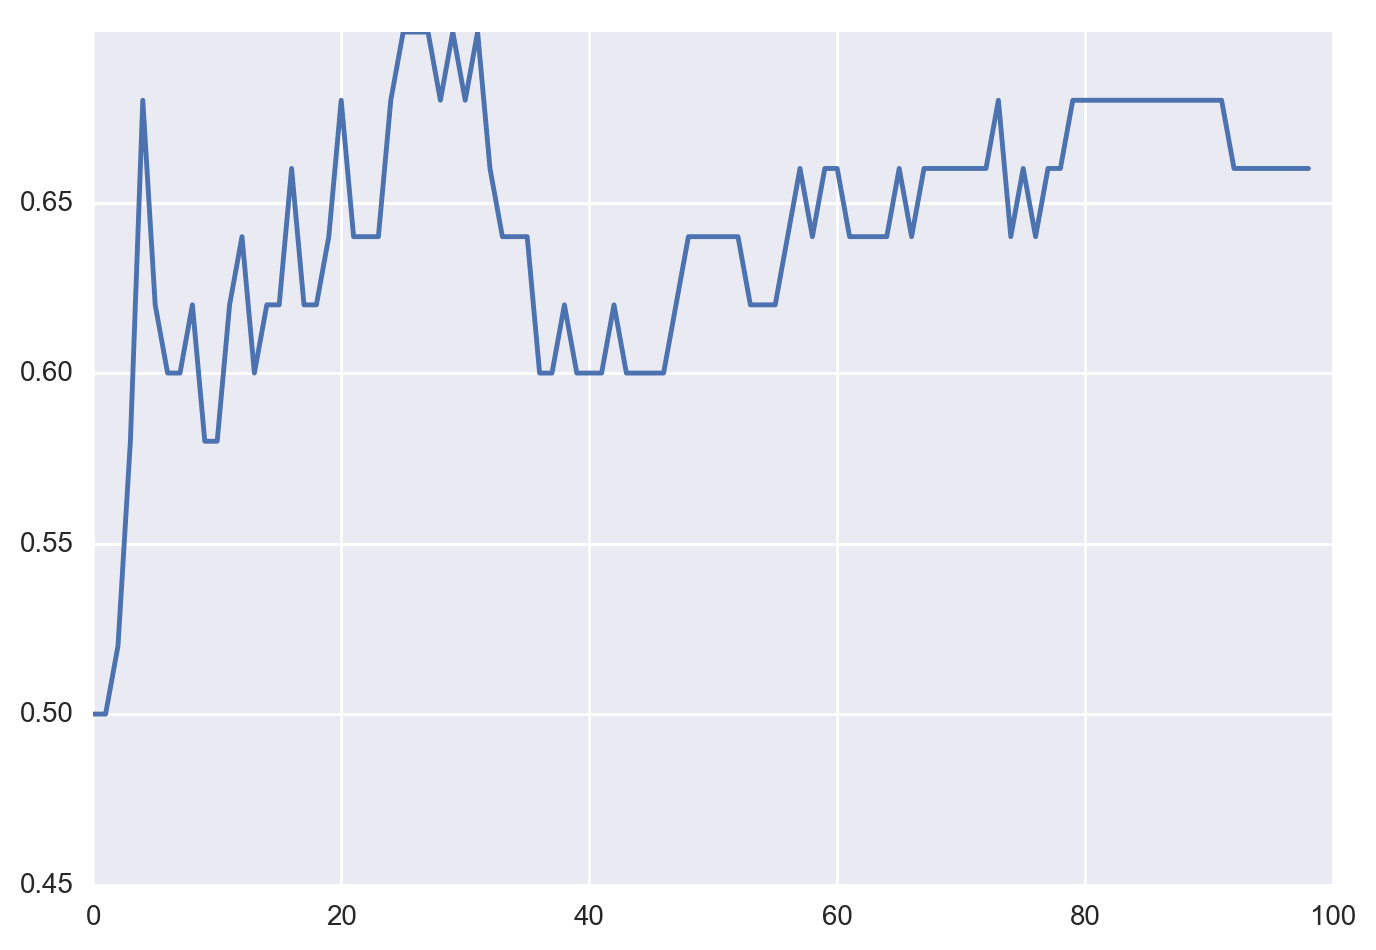

In [369]:
plt.plot(acc_list);

---

# <a name="learning_curve">5. Generate the learning curve</a>

In this section, we'll vary the size of the training set, and for each size, we'll:
* Define the test (validation) set as some fraction of posts following the training set
* For each example in the test set, evaluate the cosine similarity with each example in the training set
* Calculate the average similarity for each subreddit and assign the subreddit with the larger similarity to the example in question
* Calculate the accuracy

Start by defining the training set sizes we'll consider:

In [24]:
test_size_fraction = 0.15

In [25]:
max_train_size = int(min(lengths) / (1 + test_size_fraction))
max_train_size

4353

In [26]:
start_size = 250
step_size = 250

Do what I just described:

In [34]:
accuracy_list = []
train_size_list = []
full_cnt = 1
for train_size in range(start_size, max_train_size, step_size): 
    output_string = ("\rStep " + str(full_cnt) + " / " + 
                     str(len(range(start_size, max_train_size, step_size))))
    sys.stdout.write(output_string)
    sys.stdout.flush()
    # Define the training and test sets
    test_size = int(test_size_fraction * train_size)
    train_clean = []
    for datum in data_clean:
        train_clean = train_clean + datum[0: train_size]
    test_clean = []
    for datum in data_clean:
        test_clean = test_clean + datum[train_size: train_size + test_size]    
    # Fit the BOW on the training set and transform the test set
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                                 preprocessor = None, stop_words = None, 
                                 max_features = 5000) 
    train_bow = vectorizer.fit_transform(train_clean)
    test_bow = vectorizer.transform(test_clean)
    train_bow_array = train_bow.toarray()
    test_bow_array = test_bow.toarray()
    # Fit the TF-IDF on the training set and transform the test set
    transformer = TfidfTransformer()
    train_tfidf = transformer.fit_transform(train_bow_array)
    test_tfidf = transformer.transform(test_bow_array)
    # Calculate the similarities for each test example
    outcome = []
    for i in range(test_size * len(data_clean)):
        cosine_similarities = linear_kernel(test_tfidf[i], train_tfidf).flatten()
        sim_avgs = [cosine_similarities[s * train_size: (s + 1) * train_size].mean() for s in range(len(data))]
        index_max = sim_avgs.index(max(sim_avgs))
        outcome.append(all_subreddit_names[index_max])    
    # Calculate the accuracy
    correct_count = 0
    for s in range(len(data)):
        for o in outcome[s * test_size: (s + 1) * test_size]:
            if o == all_subreddit_names[s]: correct_count = correct_count + 1
    accuracy = correct_count / (test_size * len(data_clean))
    accuracy_list.append(accuracy)
    train_size_list.append(train_size)
    full_cnt = full_cnt + 1

Step 17 / 17

Plot the learning curve

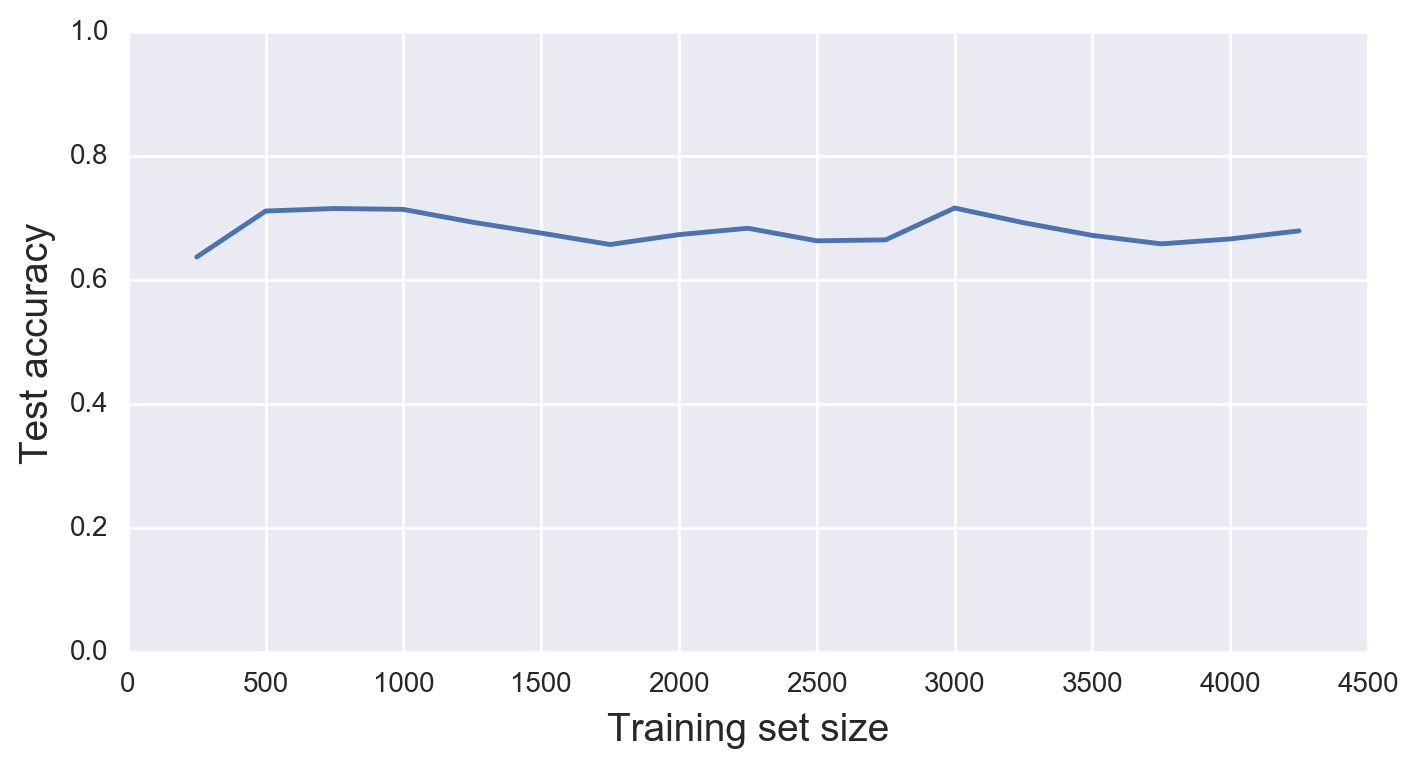

In [171]:
fig, ax = plt.subplots(figsize = (8, 4))
plt.plot(train_size_list, accuracy_list)
ax.set_xlabel("Training set size", fontsize = 14)
ax.set_ylabel('Test accuracy', fontsize = 14)
ax.set_ylim([0,1]);

In [172]:
fig.savefig('learning_curve.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

Visualize the confusion matrix -- **BUG**: mislabeled columns / rows

In [43]:
true_outcomes = []
for s in range(len(data)):
    true_outcomes = true_outcomes + test_size * [all_subreddit_names[s]]

In [94]:
conf_mat = confusion_matrix(true_outcomes, outcome)
conf_mat_rel = conf_mat / conf_mat.astype(np.float).sum(axis = 1)

In [100]:
conf_df = pd.DataFrame(conf_mat_rel * 100, index = all_subreddit_names, columns = all_subreddit_names)

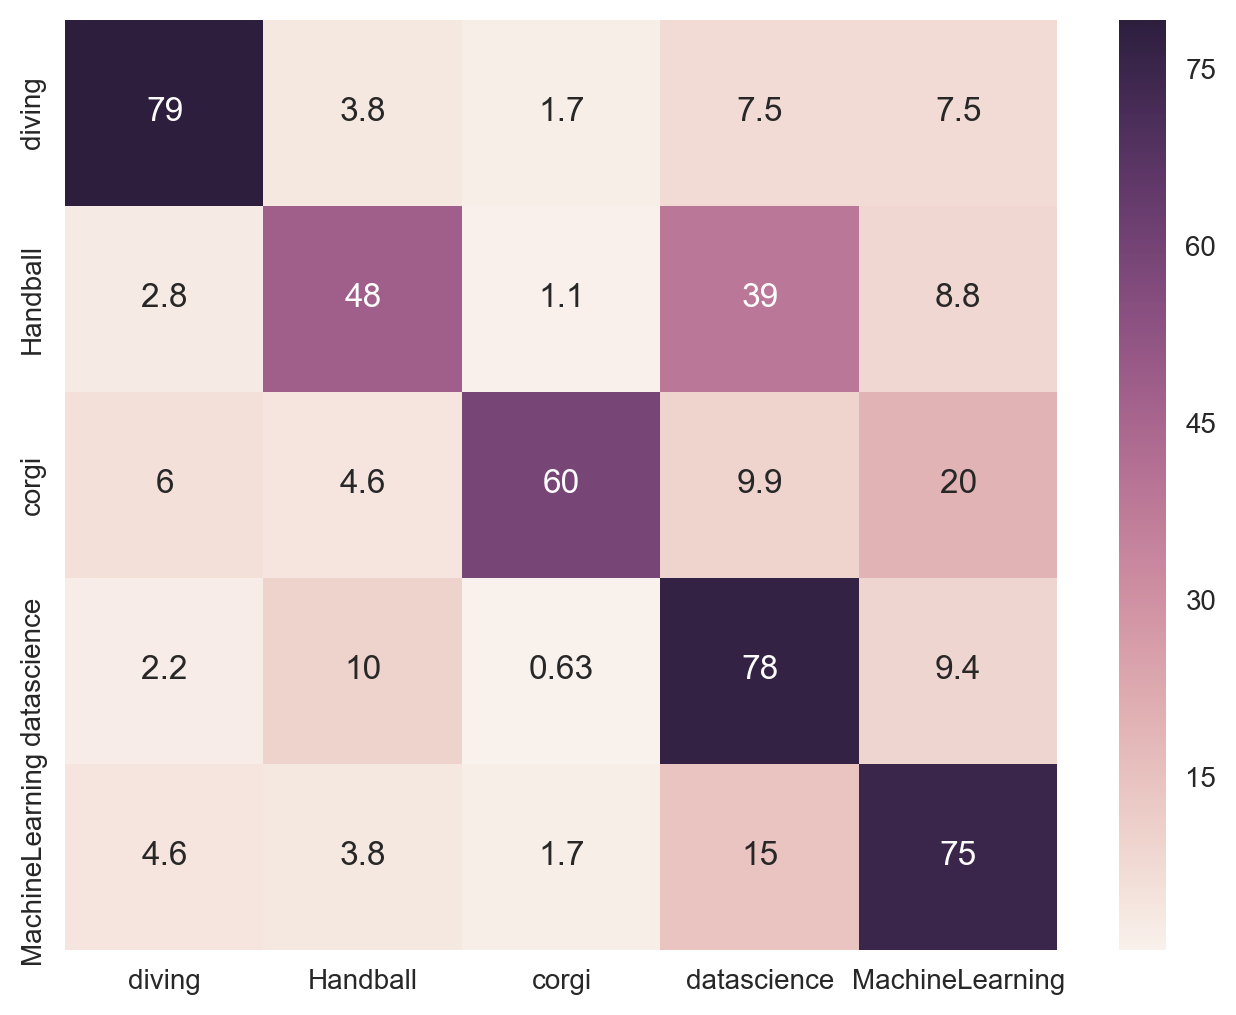

In [175]:
fig, ax = plt.subplots(figsize = (8, 6))
seaborn.heatmap(conf_df, annot = True, ax = ax);

In [176]:
fig.savefig('confusion_matrix.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

In [92]:
con.close()

---

# <a name="slack_bot">6. Slackbot</a>

Our Slack officer is called Newman and here are his credentials:

In [27]:
bot_token = os.environ["SLACKBOT_TOKEN_NEWMAN"]
bot_name = 'officer_newman'

Initialize the Slack client and find out its ID (so we can filter its messages):

In [28]:
slack_client = SlackClient(bot_token)

In [29]:
users = slack_client.api_call("users.list").get('members')
for user in users:
    if 'name' in user and user.get('name') == bot_name:
        bot_id = user.get('id')
bot_id

u'U3WF8D4SX'

Let's train the BOW & TF-IDF on our entire training corpus again:

In [30]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                             preprocessor = None, stop_words = None, 
                             max_features = 5000) 
transformer = TfidfTransformer()

In [31]:
all_bow = vectorizer.fit_transform(all_clean)
all_bow_array = all_bow.toarray()
all_tfidf = transformer.fit_transform(all_bow_array)

Let's find the channel ID's:

In [32]:
channel_list = slack_client.api_call("channels.list")['channels']
[(c['id'], c['name']) for c in channel_list]

[(u'C3WJDNPCJ', u'ex1_diving'),
 (u'C3WJDPEHG', u'ex2_handball'),
 (u'C3WV35AEN', u'ex3_corgi'),
 (u'C3W93G2F3', u'ex4_data_science'),
 (u'C3XKZSM1V', u'ex5_machine_learning'),
 (u'C3UTPTUMT', u'general'),
 (u'C3UTDRVT6', u'random')]

Select the relevant ones:

In [33]:
all_subreddit_names

['diving', 'Handball', 'corgi', 'datascience', 'MachineLearning']

In [34]:
all_channel_ids = [c['id'] for c in channel_list if 'ex' in c['name']]
all_channel_names = [c['name'] for c in channel_list if 'ex' in c['name']]
print all_channel_names
print all_channel_ids

[u'ex1_diving', u'ex2_handball', u'ex3_corgi', u'ex4_data_science', u'ex5_machine_learning']
[u'C3WJDNPCJ', u'C3WJDPEHG', u'C3WV35AEN', u'C3W93G2F3', u'C3XKZSM1V']


This function will check if the output from Slack came from a user as a text message:

In [35]:
def parse_slack_output(slack_rtm_output):
    output_list = slack_rtm_output
    if output_list and len(output_list) > 0:
        for output in output_list:
            if output and 'text' in output and 'user' in output:
                return output['text'].strip().lower(), output['channel'], output['user']
    return None, None, None

If so, we then find the TF-IDF representation of the output and calculate the average similarity across channels. The one with the highest average similarity wins, and if the post was posted in a different channel, the bot posts the message indicating this.

In [36]:
indices = [0] * (len(data)+1)
for i in range(1, len(data)+1):
    indices[i] = indices[i-1] + len(data[i-1])

In [37]:
def handle_input(input_string, channel, user):
    # TF-IDF representation of the input
    input_tokenized = clean_post(input_string)
    input_clean = " ".join(input_tokenized)
    input_bow = vectorizer.transform([input_clean])
    input_bow_array = input_bow.toarray()
    input_tfidf = transformer.transform(input_bow_array)
    # Calculate the similarities and predict the channel  
    cosine_similarities = linear_kernel(input_tfidf, all_tfidf).flatten()
    sim_avgs = [cosine_similarities[indices[s]: indices[s + 1]].mean() for s in range(len(data))]
    index_max = sim_avgs.index(max(sim_avgs))
    predicted_channel = all_channel_ids[index_max]    
    # Check if you're in the right channel
    if predicted_channel != channel and user != bot_id:
        response = ("Hey <@" + user + ">, consider posting this in the <#" + 
                    predicted_channel + "> channel.")
        slack_client.api_call("chat.postMessage", channel = channel,
                              text = response, as_user = True)

Open the Slack RTM firehose:

In [38]:
if slack_client.rtm_connect():
    print("officer_newman connected and monitoring...")
    while True:
        command, channel, user = parse_slack_output(slack_client.rtm_read())
        if command and channel:
            handle_input(command, channel, user)
        time.sleep(1)
else:
    print("Connection failed.")

officer_newman connected and monitoring...


KeyboardInterrupt: 